In [1]:
import numpy as np

In [2]:
collision = np.load('.data/Time_series_colisao.npz')
display(collision.keys())
spreading = np.load('.data/Time_series_espalhamento.npz')
display(spreading.keys())

KeysView(NpzFile '.data/Time_series_colisao.npz' with keys: TS, Re, We, B)

KeysView(NpzFile '.data/Time_series_espalhamento.npz' with keys: TS, Re, We, Fr, V0...)

# Colisão | Collision

In [3]:
collision_timesteps_raw = collision['TS']
display(collision_timesteps_raw.shape)

(72, 1000, 5)

In [4]:
components: list[dict] = list()
for i in range(5):
    components.append({
        "original": collision_timesteps_raw[:, :, i].T
    })

In [5]:
from typing import Literal
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, MaxAbsScaler, QuantileTransformer, PowerTransformer, Normalizer


chosen_scaler: Literal[
    'StandardScaler',
    'MinMaxScaler',
    'RobustScaler',
    'MaxAbsScaler',
    'QuantileTransformer',
    'PowerTransformer',
    'Normalizer'
] = 'MaxAbsScaler'
for component_dict in components:
    component_dict["scaler"] = eval(chosen_scaler)()
    component_dict["scaled"] = component_dict["scaler"].fit_transform(component_dict["original"])

In [6]:
import numpy as np
from keras.models import Model
from keras.layers import Dense, Input
from keras.optimizers import Adam
from keras.metrics import mean_squared_error, mean_absolute_percentage_error
from keras.callbacks import LearningRateScheduler, ModelCheckpoint
from uuid import uuid4

def generate_autoencoder():
    input = Input(shape=(72,))
    hidden_1 = Dense(36, activation='linear')(input)
    hidden_2 = Dense(18, activation='linear')(hidden_1)
    encoding_dim = Dense(9, activation='linear')(hidden_2)
    hidden_3 = Dense(18, activation='linear')(encoding_dim)
    hidden_4 = Dense(36, activation='linear')(hidden_3)
    output = Dense(72, activation='linear')(hidden_4)
    model = Model(input, output)
    optim = Adam(learning_rate=0.1)
    model.compile(
        optimizer=optim,
        loss='mean_absolute_percentage_error',
        metrics=[
            mean_squared_error,
            mean_absolute_percentage_error
        ])
    return model


def scheduler(epoch, lr):
    power = - 0.04 * epoch
    if epoch < 100:
        return 0.1 * np.e ** power
    else:
        return 0.001


def train_autoencoder(autoencoder, data):    
    lr_scheduler = LearningRateScheduler(schedule=scheduler)
    model_uuid = uuid4()
    checkpoint = ModelCheckpoint(filepath=f"/tmp/{model_uuid}/model.weights.h5", monitor="loss", verbose=1, save_best_only=True, save_weights_only=True)
    history = autoencoder.fit(
        data, data,
        batch_size = 15,
        epochs=150,
        verbose=True,
        shuffle=True,
        callbacks=[
            lr_scheduler,
            checkpoint
        ]
    )
    return history

2024-04-01 11:23:58.017226: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-01 11:23:58.059866: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-01 11:23:58.999537: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [7]:
permutation_idx = np.random.permutation(collision_timesteps_raw.shape[1])
for component in components:
    component["model"] = generate_autoencoder()
    component["training_data"] = component["scaled"][permutation_idx[:666]]
    component["training_history"] = train_autoencoder(component["model"], component["training_data"])

Epoch 1/150
 1/45 ━━━━━━━━━━━━━━━━━━━━ 1:00 1s/step - loss: 115.7108 - mean_absolute_percentage_error: 115.7108 - mean_squared_error: 0.8283
Epoch 1: loss improved from inf to 2266.43530, saving model to /tmp/54ef9a75-dddd-4714-b9fb-d104e5393824/model.weights.h5
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 3471.5181 - mean_absolute_percentage_error: 3472.7307 - mean_squared_error: 1569.0193 - learning_rate: 0.1000
Epoch 2/150
 1/45 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 109.2175 - mean_absolute_percentage_error: 109.2175 - mean_squared_error: 0.8844
Epoch 2: loss improved from 2266.43530 to 44.34013, saving model to /tmp/54ef9a75-dddd-4714-b9fb-d104e5393824/model.weights.h5
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 69.8383 - mean_absolute_percentage_error: 69.8557 - mean_squared_error: 0.4024 - learning_rate: 0.0961
Epoch 3/150
 1/45 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 19.5999 - mean_absolute_percentage_error: 19.5999 - mean_squared_error: 0.0261
Epoch 3: loss improved 

In [8]:
# testing
for component in components:
    component["testing_data_scaled"] = component["scaled"][permutation_idx[666:]]
    component["prediction_scaled"] = component["model"].predict(component["testing_data_scaled"])
    component["testing_data_unscaled"] = component["scaler"].inverse_transform(component["testing_data_scaled"])
    component["prediction_unscaled"] = component["scaler"].inverse_transform(component["prediction_scaled"])

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


In [9]:
import pandas as pd

pd.set_option('display.float_format', '{:.4f}'.format)

columns = pd.MultiIndex.from_product([['MSE', 'MAPE'], ['min', 'max', 'mean']])
data = np.zeros((5, 6))
result_df = pd.DataFrame(
    data,
    index=pd.RangeIndex(0, 5, name="Component"),
    columns=columns
)

for i, component in enumerate(components):
    mse_loss = mean_squared_error(component["testing_data_unscaled"], component["prediction_unscaled"])
    mape_loss = mean_absolute_percentage_error(component["testing_data_unscaled"], component["prediction_unscaled"])
    result_df.loc[i, ("MSE", "min")] = np.min(mse_loss)
    result_df.loc[i, ("MSE", "max")] = np.max(mse_loss)
    result_df.loc[i, ("MSE", "mean")] = np.mean(mse_loss)
    result_df.loc[i, ("MAPE", "min")] = np.min(mape_loss)
    result_df.loc[i, ("MAPE", "max")] = np.max(mape_loss)
    result_df.loc[i, ("MAPE", "mean")] = np.mean(mape_loss)

display("Distribuição de erros quadráticos médios e erro médio absoluto percentual para cada componente")
display(result_df)

'Distribuição de erros quadráticos médios e erro médio absoluto percentual para cada componente'

MSE                                         MAPE  \
                      min              max             mean        min   
Component                                                                
0                  0.0001           0.0144           0.0041     0.6671   
1                  0.0002           0.0224           0.0048     0.7813   
2                  0.7407        5740.3105         148.3228     4.4861   
3                 11.5685         757.9314          89.0527     0.3736   
4         9642160128.0000 84268843008.0000 34085105664.0000 16474.5684   

                                  
                  max       mean  
Component                         
0              4.8529     2.7076  
1              6.2943     2.5434  
2             20.3139     9.5754  
3              2.3745     0.9232  
4         375820.5938 23417.3066

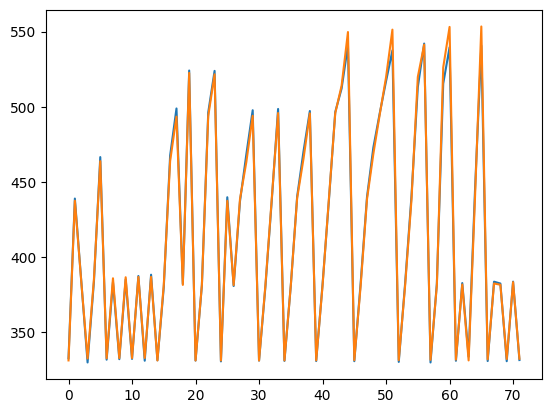

In [10]:
import matplotlib.pyplot as plt

plt.plot(components[3]["prediction_unscaled"][3])
plt.plot(components[3]["testing_data_unscaled"][3])
plt.show()

##### Demonstrating that this transpose makes sense

In [ ]:
# Let's test if this is correct
# Suppose we have tree simulations with 2 components each
# We have 3 timesteps
# First component is linear, second is quadratic
# First simulation starts with 1
# Second simulation starts with 2
# Third simulation starts with 3
# Therefore, first simulation first component is [1, 2, 3]
# Second simulation first component is [2, 3, 4]
# Third simulation first component is [3, 4, 5]
# First simulation second component is [1, 4, 9]
# Second simulation second component is [4, 9, 16]
# Third simulation second component is [9, 16, 25]
# Therefore, first timestep is [[1, 2, 3], [1, 4, 9]]
first_simulation = np.array([[1, 1], [2, 4], [3, 9]])
second_simulation = np.array([[2, 4], [3, 9], [4, 16]])
third_simulation = np.array([[3, 9], [4, 16], [5, 25]])
timesteps = np.array([first_simulation, second_simulation, third_simulation])
shape = timesteps.shape
display(shape)
transformed_timesteps = timesteps.transpose(1, 0, 2).reshape(shape[1], shape[0] * shape[2])
display(transformed_timesteps)